### Setup

In [1]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 115.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 15.9 MB/s eta 0:00:00

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np 

import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/imbd/IMDB Dataset.csv')

### Data Loading

In [4]:
## We will work only with a small subset of the original data to accelerate training ...
data = data.iloc[:10000,:]

In [5]:
data.sentiment = data.sentiment.map({'positive':1, 'negative':0})
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [10]:
## Revies #Words
data.review.apply(lambda x : len(x.split())).median()

172.0

### BERT Embedding : 
We will use TensorFlow Hub which is a repository of trained machine learning models like BERT ready for fine-tuning and deployable anywhere.

In [14]:
bert_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
bert_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [16]:
bert_preprocess = hub.KerasLayer(bert_preprocess)
bert_model = hub.KerasLayer(bert_encoder)

In [18]:
test = ['One of the other reviewers has mentioned that after watching']
text_preprocessed = bert_preprocess(test)
text_embedding = bert_model(text_preprocessed)

print('Keys : ', list(text_preprocessed.keys()))

# 128 tockens as default but we can change it.
print('Shape : ', text_preprocessed["input_word_ids"].shape)

print('Pooled Outputs Shape : ', text_embedding["pooled_output"].shape)
print('Sequence Outputs Shape : ' ,text_embedding["sequence_output"].shape)

Keys :  ['input_mask', 'input_word_ids', 'input_type_ids']
Shape :  (1, 128)
Pooled Outputs Shape :  (1, 768)
Sequence Outputs Shape :  (1, 128, 768)


In [19]:
x_train = tf.convert_to_tensor(data.review[0:8000], dtype=None, dtype_hint=tf.float32, name=None)
x_test = tf.convert_to_tensor(data.review[8000:], dtype=None, dtype_hint=tf.float32, name=None)

y_train = tf.convert_to_tensor(data.sentiment[:8000], dtype=None, dtype_hint=tf.int32, name=None)
y_test = tf.convert_to_tensor(data.sentiment[8000:], dtype=None, dtype_hint=tf.int32, name=None)

In [20]:
x_train.shape

TensorShape([8000])

### Transformer block and Position embedding as a layers

I used this keras [tutorial](https://keras.io/examples/nlp/text_classification_with_transformer/) for the transformer block.

In [21]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionEmbedding(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.pos_encoding = positional_encoding(max_len, embed_dim)
 
    def call(self, x):
        seq_len = tf.shape(x)[1]
        x += self.pos_encoding[:, :seq_len, :]
        return x

### Modelling

In [22]:
embed_dim = 768  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 2048  # Hidden layer size in feed forward network inside transformer

In [24]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(bert_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(bert_model, trainable=False, name='BERT_encoder')
out = encoder(encoder_inputs)
net = out['sequence_output']

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
embedding_layer = PositionEmbedding(128, 2000, embed_dim)

x = embedding_layer(net)

x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)

x = layers.Dropout(0.2)(x)
x = layers.Dense(ff_dim, activation="relu", name = 'FNN')(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=text_input, outputs=outputs)

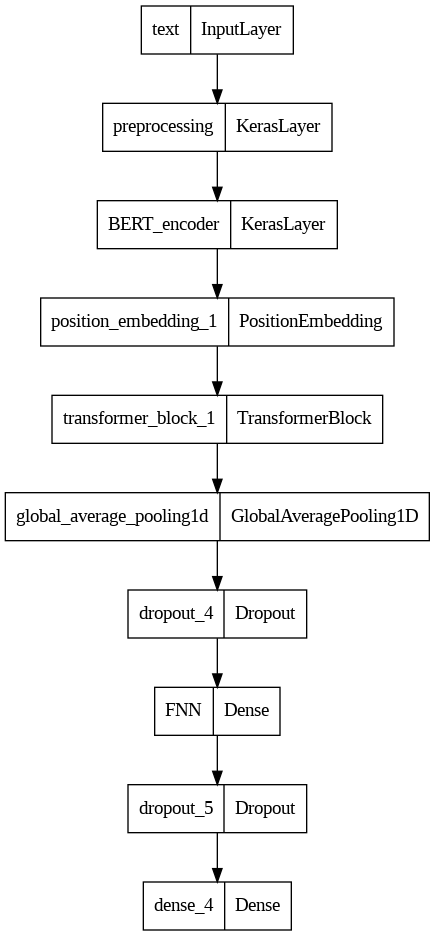

In [25]:
tf.keras.utils.plot_model(model)

### Training and Evaluation

In [26]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=16, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
500/500 [==============================] - 149s 272ms/step - loss: 0.7106 - accuracy: 0.5734 - val_loss: 0.7172 - val_accuracy: 0.6050
Epoch 2/20
500/500 [==============================] - 115s 230ms/step - loss: 0.5097 - accuracy: 0.7523 - val_loss: 0.4723 - val_accuracy: 0.7765
Epoch 3/20
500/500 [==============================] - 115s 230ms/step - loss: 0.5104 - accuracy: 0.7515 - val_loss: 0.5066 - val_accuracy: 0.7550
Epoch 4/20
500/500 [==============================] - 135s 271ms/step - loss: 0.4594 - accuracy: 0.7895 - val_loss: 0.4746 - val_accuracy: 0.7820
Epoch 5/20
500/500 [==============================] - 135s 270ms/step - loss: 0.4711 - accuracy: 0.7854 - val_loss: 0.4902 - val_accuracy: 0.7865
Epoch 6/20
500/500 [==============================] - 121s 242ms/step - loss: 0.4460 - accuracy: 0.7976 - val_loss: 0.4666 - val_accuracy: 0.7875
Epoch 7/20
500/500 [==============================] - 119s 239ms/step - loss: 0.4657 - accuracy: 0.7847 - val_loss: 0.4452 -

In [27]:
import matplotlib.pyplot as plt 
%matplotlib inline

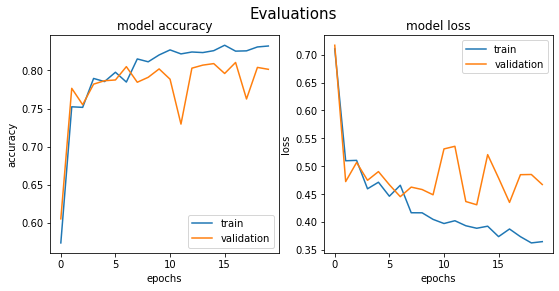

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
fig.suptitle('Evaluations', fontsize = 15)

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epochs')
ax1.legend(['train', 'validation'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epochs')
ax2.legend(['train', 'validation'])

fig = plt.gcf()
plt.show()